### Single-cell RNAseq complete workflow
#### Dataset is described here: Carpenter ES, Elhossiny AM, Kadiyala P, Li J et al. Analysis of Donor Pancreata Defines the Transcriptomic Signature and Microenvironment of Early Neoplastic Lesions. Cancer Discov 2023 Jun 2;13(6):1324-1345
#### Raw matrices were downloaded from GEO NCBI : GSE229413 

#### 1. Import necessary libraries

In [2]:
import os
import scanpy as sc
import scrublet as scr
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import harmonypy as hm
import celltypist
from celltypist import models
import seaborn as sns
import scvi
from scvi.model import SCVI

C:\Users\ksenia\anaconda3\Lib\site-packages\celltypist\classifier.py:11: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  from scanpy import __version__ as scv


#### 2. Remove ambient RNA
###### Use Cellbender; the command was run in AWS VM with GPU (1 GPU, 16 Gb Ram, 4vCPU, 48 hours to examine 32 files)
###### The output files are available here : 
##### Cellbender command line : cellbender remove-background --input GSM7162998_3829-EC_raw_feature_bc_matrix.h5 --output GSM7162998_3829-EC_denoised.h5 --expected-cells 10000 --total-droplets-included 50000 --epochs 150 --cuda

In [3]:
# Upload the matrices after ambient RNA removal
# Explore the metrics

base_dir_metrics = "//wsl.localhost/Ubuntu/home/ksenia/cellbender_out/output_metrics"
files_metrics = os.listdir(base_dir_metrics)

metrics = []

for f in files_metrics:
    full_path = os.path.join(base_dir_metrics, f)
    df = pd.read_csv(full_path, header=None, names=['Metric', 'Value'])
    df = df.set_index('Metric').T
    df['sample'] = f
    metrics.append(df)

metrics = pd.concat(metrics).reset_index()
cols = ['sample'] + [c for c in metrics.columns if c != 'sample']
metrics = metrics[cols]

In [19]:
# metrics

array([[<Axes: title={'center': 'fraction_counts_removed_from_cells'}>]],
      dtype=object)

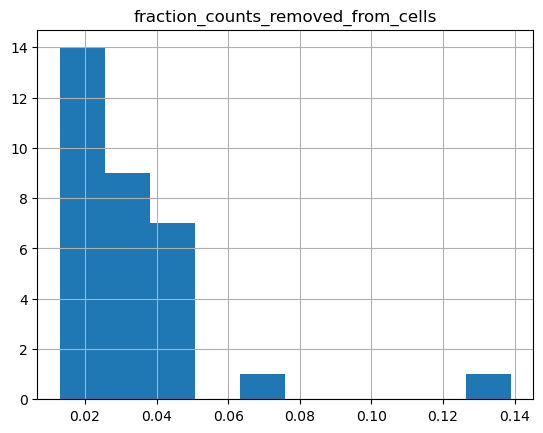

In [3]:
# Visualize the fraction of counts removed from cells
metrics.hist(['fraction_counts_removed_from_cells'])

In [4]:
# Upload metadta file with sample_id, donor_id and lesion information
metadata = pd.read_excel("//wsl.localhost/Ubuntu/home/ksenia/Sample_data.xlsx")
print(metadata.head(5))

                                   File_id sample_id donor_id  lesion
0  GSM7162998_3829-EC_denoised_filtered.h5   3829-EC  Donor_1  Lesion
1  GSM7162999_3861-EC_denoised_filtered.h5   3861-EC  Donor_2      No
2  GSM7163000_3862-EC_denoised_filtered.h5   3862-EC  Donor_2      No
3  GSM7163001_4160-EC_denoised_filtered.h5   4160-EC  Donor_4      No
4  GSM7163002_4161-EC_denoised_filtered.h5   4161-EC  Donor_4      No


In [5]:
# Upload h5 files after ambient RNA removal

# Load metadata file 
metadata_file = r"\\wsl.localhost\Ubuntu\home\ksenia\Sample_data.xlsx"  
metadata = pd.read_excel(metadata_file)  

# Folder with h5 files
h5_dir = r"C:\Users\ksenia\output_filtered_h5"

# Load h5 files and attach metadata 
adatas = {}  # dictionary to store AnnData objects

for idx, row in metadata.iterrows():
    filename = row["File_id"]
    full_path = os.path.join(h5_dir, filename)
    
    # Load the 10x h5 file
    adata = sc.read_10x_h5(full_path)
    
    # Add metadata columns
    adata.obs["sample_id"] = row["sample_id"]
    adata.obs["donor_id"] = row["donor_id"]
    adata.obs["lesion"] = row["lesion"]
    
    # Store in dictionary keyed by sample_id
    adatas[row["sample_id"]] = adata

In [6]:
adatas.keys()

dict_keys(['3829-EC', '3861-EC', '3862-EC', '4160-EC', '4161-EC', '4346-EC', '4347-EC', '4450-EC', '4451-EC', '4637-EC-1', '4637-EC-2', '4741-EC-1', '4741-EC-2', 119833, 125796, 135041, 125421, 126197, 123798, 127260, 129444, 130289, 130450, 130840, 130742, 135040, 135156, 137333, 135334, 135714, 136365, 136687])

In [7]:
adatas["3829-EC"]

AnnData object with n_obs × n_vars = 17234 × 36601
    obs: 'sample_id', 'donor_id', 'lesion'
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
adatas["3829-EC"].obs.head(3)

,sample_id,donor_id,lesion
TACCGAACATCGATGT-1,3829-EC,Donor_1,Lesion
CACTGTCTCCCTTTGG-1,3829-EC,Donor_1,Lesion
GGTTAACAGCAACTCT-1,3829-EC,Donor_1,Lesion


In [9]:
adatas["3829-EC"].var.head(3)

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38


In [10]:
adatas["3829-EC"].X.shape

(17234, 36601)

#### 3. Ribosomal gene annotation for futher regress out

In [11]:
# Ribosomal genes
# Upload a GMT file with ribosomal genes' names (downloaded form the Broad Institute)
gmt_file = "C:/Users/ksenia/KEGG_RIBOSOME.v2025.1.Hs.gmt"

# Read the GMT file line by line
gene_sets = []
with open(gmt_file) as f:
    for line in f:
        parts = line.strip().split("\t")  # GMT is tab-delimited
        gene_set_name = parts[0]
        description = parts[1]
        genes = parts[2:]  # remaining columns are gene symbols
        for g in genes:
            gene_sets.append([gene_set_name, description, g])

# Convert to DataFrame
df_ribo = pd.DataFrame(gene_sets, columns=['gene_set', 'description', 'gene'])
ribo_genes = df_ribo['gene'].unique().tolist()
print(f"Number of ribosomal genes: {len(ribo_genes)}")

Number of ribosomal genes: 88


In [12]:
for key in adatas.keys():
    adatas[key].var['Ribosomal'] = adatas[key].var_names.isin(df_ribo['gene'].values) # add True/False when a gene is ribosomal or not

In [13]:
for key in adatas.keys():
    sc.pp.calculate_qc_metrics(adatas[key], qc_vars=['Ribosomal'], percent_top=None, log1p = False, inplace=True)

In [14]:
adatas["3829-EC"].obs.head(3)

,sample_id,donor_id,lesion,n_genes_by_counts,total_counts,total_counts_Ribosomal,pct_counts_Ribosomal
TACCGAACATCGATGT-1,3829-EC,Donor_1,Lesion,9730,781255,160919,20.59750
CACTGTCTCCCTTTGG-1,3829-EC,Donor_1,Lesion,9772,756935,191638,25.31763
GGTTAACAGCAACTCT-1,3829-EC,Donor_1,Lesion,10572,635900,159201,25.03554


In [ ]:
# Explore violin plots : % of ribosomal counts per sample
# for key in adatas.keys():
#    sc.pl.violin(adatas[key], ['pct_counts_Ribosomal'], jitter=0.4, multi_panel=True)

#### 4. QC filtering according to Carpenter et al. (2023)

In [15]:
# QC filtering for a single AnnData object
# Keep cells with >= min_genes_per_cell detected genes
# Keep genes expressed in >= min_cells_per_gene cells
# Remove cells with > max_mt% mitochondrial counts

def qc_filter(adata, min_genes_per_cell=200, min_cells_per_gene=3, max_mt=15, max_ribo=45):
    adata.var['mt'] = adata.var.index.str.startswith('MT-') # mitochondrial genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'Ribosomal'], inplace=True) # calculate QC metrics
    cell_filter = (adata.obs['n_genes_by_counts'] >= min_genes_per_cell) & (adata.obs['pct_counts_mt'] <= max_mt) & (adata.obs['pct_counts_Ribosomal'] <= max_ribo)  
    adata._inplace_subset_obs(cell_filter) # filter cells
    sc.pp.filter_genes(adata, min_cells=min_cells_per_gene) # filter genes
    
    return adata

# Apply QC to all adatas in the dictionary
for key in adatas.keys():
    adatas[key] = qc_filter(adatas[key])

In [61]:
#for key in adatas.keys():
#   print(adatas[key].X.shape)

#### 5. Doublet removal using Scrublet

In [16]:
# Loop over all AnnData objects
for key in adatas.keys():
    adata = adatas[key]
    print(f"\nRunning Scrublet for {key} ({adata.n_obs} cells)")
    
    # Prepare counts matrix (cells x genes)
    counts_matrix = adata.X.copy()
    scrub = scr.Scrublet(counts_matrix)
    
    # Compute doublet scores
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    # If automatic threshold fails, pick a reasonable default (0.25)
    if predicted_doublets is None:
        print(f"Warning: automatic threshold failed for {key}. Using threshold=0.25")
        predicted_doublets = scrub.call_doublets(threshold=0.25)
    
    # Store scores and predictions in adata.obs
    adata.obs['doublet_score'] = doublet_scores
    adata.obs['predicted_doublet'] = predicted_doublets
    
    # Remove predicted doublets
    adata_filtered = adata[~predicted_doublets, :].copy()
    
    # Replace original adata with filtered one
    adatas[key] = adata_filtered
    
    print(f"{key}: {adata_filtered.n_obs} cells remaining after Scrublet")


Running Scrublet for 3829-EC (10210 cells)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 4.3%
Estimated detectable doublet fraction = 33.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.9%
Elapsed time: 72.9 seconds
3829-EC: 9772 cells remaining after Scrublet

Running Scrublet for 3861-EC (5244 cells)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 27.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 20.4 seconds
3861-EC: 5174 cells remaining after Scrublet

Running Scrublet for 3862-EC (4644 cells)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set thresho

In [17]:
adata.obs.columns

Index(['sample_id', 'donor_id', 'lesion', 'n_genes_by_counts', 'total_counts',
       'total_counts_Ribosomal', 'pct_counts_Ribosomal',
       'log1p_n_genes_by_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'log1p_total_counts_Ribosomal', 'doublet_score', 'predicted_doublet'],
      dtype='object')

#### 6. Concatenate all adata objects (each object correspond to the count matrix)

In [18]:
# Make gene names unique in each AnnData object before concatenation
for key in adatas.keys():
    adatas[key].var_names_make_unique()

# Concatenate the samples
adata_all = sc.concat(adatas, join="outer", label="sample_id", index_unique="-")

#### 7. Normalize and log counts

In [18]:
sc.pp.normalize_total(adata_all, target_sum = 1e4) # normalize every cell to 10,000 UMI

In [19]:
sc.pp.log1p(adata_all) # change to log count to avoid very large ranges

#### 8. Correction for cell cycle effect

In [24]:
# Cell cycle gene lists
from scanpy.tl import score_genes_cell_cycle

# Upload standard lists from Tirosh et al.
# S phase genes
s_genes = [
    "MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG","GINS2",
    "MCM6","CDCA7","DTL","PRIM1","UHRF1","HELLS","RFC2","RPA2","NASP",
    "RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7","POLD3","MSH2",
    "ATAD2","RAD51","RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1","BLM",
    "CASP8AP2","USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8"
]

# G2M phase genes
g2m_genes = [
    "HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A","NDC80",
    "CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF","TACC3","FAM64A",
    "SMC4","CCNB2","CKAP2L","CKAP2","AURKB","BUB1","KIF11","ANP32E",
    "TUBB4B","GTSE1","KIF20B","HJURP","CDCA3","HN1","CDC20","TTK",
    "CDC25C","KIF2C","RANGAP1","NCAPD2","DLGAP5","CDCA2","CDCA8",
    "ECT2","KIF23","HMMR","AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE"
]

In [25]:
# Score cell cells
sc.tl.score_genes_cell_cycle(adata_all, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'lesion' as categorical
... storing 'phase' as categorical


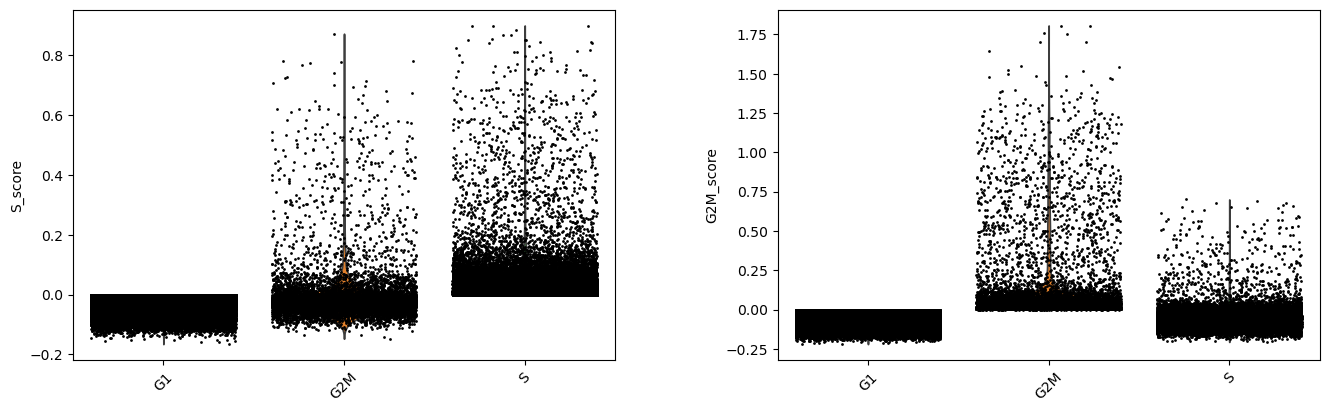

In [22]:
# Visualize the scores
sc.pl.violin(adata_all, ['S_score', 'G2M_score'], groupby='phase', jitter=0.4, size=2, rotation=45)

#### (!) Save normalized data before scaling because sclailing destroys absolute expression information (necessary for future diff expression analysis)

In [25]:
# Save normalized data before scaling because sclailing destroys absolute expression information (necessary for future diff expression analysis)
adata_all.raw = adata_all

#### 9. Select highly variable genes

In [26]:
adata_all.obs["donor_id"] = adata_all.obs["donor_id"].astype("category") # make donor_id categorical var
sc.pp.highly_variable_genes(adata_all, n_top_genes=2000, batch_key='donor_id') # select 2000 highly variable genes

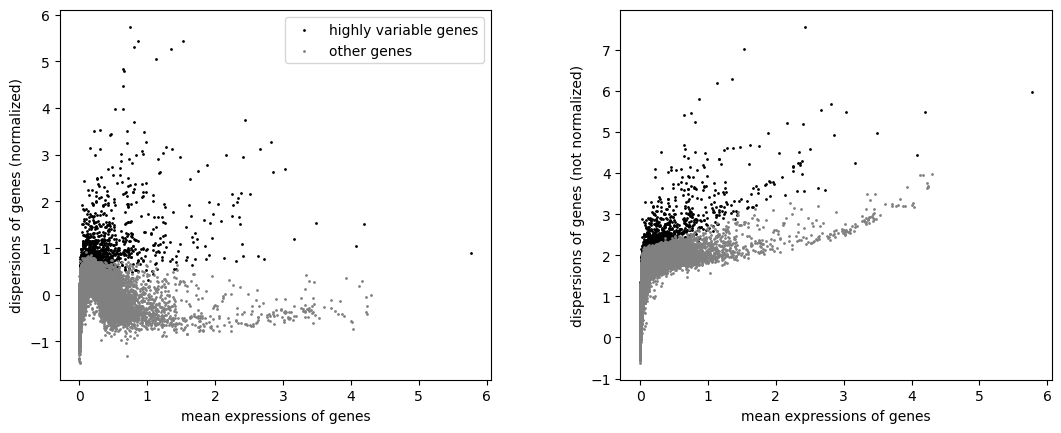

In [27]:
# HVG plot
sc.pl.highly_variable_genes(adata_all)

In [28]:
# Subset HVGs
adata_all_hvg = adata_all[:, adata_all.var.highly_variable].copy()

# Remove cells with sample status 'Unknown' (lesion/tumor/no)
# Clean lesion labels
adata_all_hvg.obs["lesion"] = adata_all_hvg.obs["lesion"].str.strip()
adata_all_hvg = adata_all_hvg[adata_all_hvg.obs["lesion"] != "Unknown", :].copy()

In [29]:
adata_all_hvg.obs["lesion"].value_counts()

lesion
Tumor     55516
Lesion    24406
No        17421
Name: count, dtype: int64

#### 10. Regress out cell cycle (it is also possible to regression out pct_mt and pct_Ribosomal)

In [32]:
sc.pp.regress_out(adata_all_hvg, ['S_score', 'G2M_score']) # regress out cell cycle gene markers

#### 11. Scale gene expression (mean = 0, var = 1)

In [33]:
# Scale gene expression
sc.pp.scale(adata_all_hvg, max_value=10)

#### Check UMAP without vs with batch effect correction

#### 12. Without batch effect correction

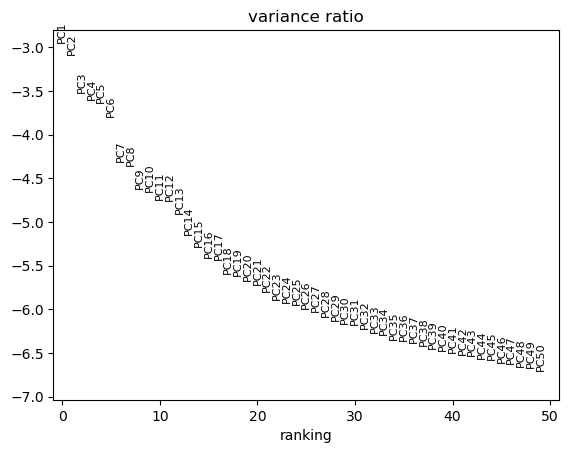

In [34]:
sc.tl.pca(adata_all_hvg, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_all_hvg, log=True, n_pcs=50)

In [36]:
# Take first 35 PCs (Carpenter et al., 2023) to project them in 2-dimentional space
# Compute neighbors graph
sc.pp.neighbors(adata_all_hvg, n_pcs=35)

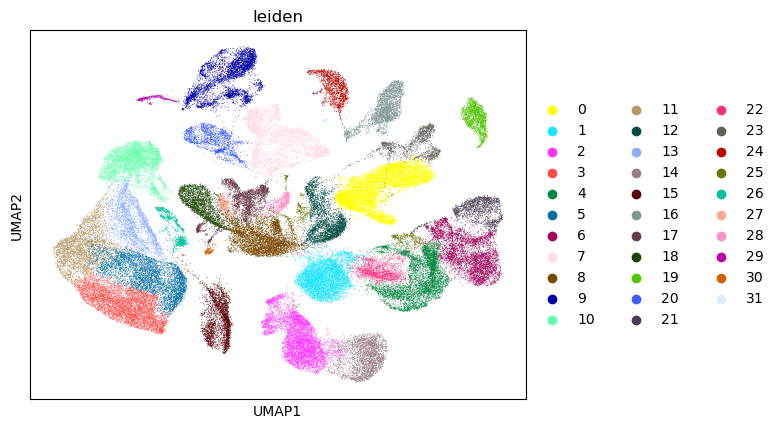

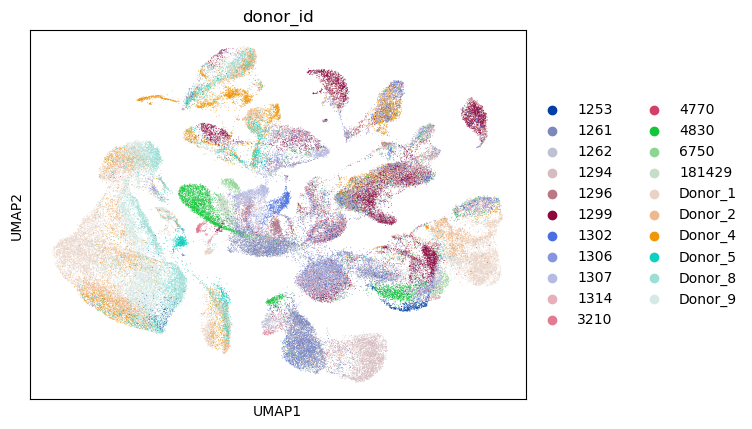

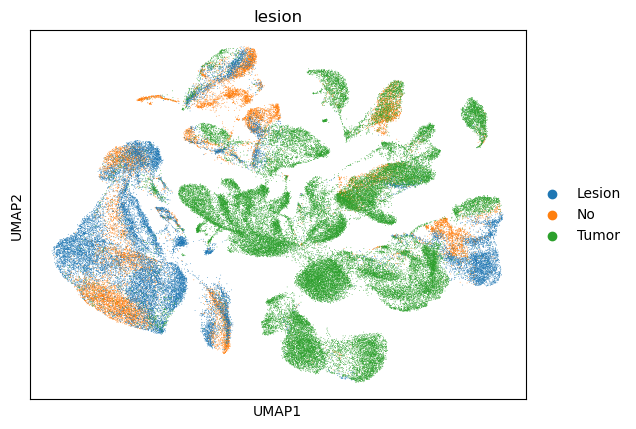

In [38]:
# Compute clusters
sc.tl.leiden(adata_all_hvg, resolution=0.5)
# Compute UMAP embedding
sc.tl.umap(adata_all_hvg)
# Plot UMAP colored by cluster, donor, and lesion
sc.pl.umap(adata_all_hvg, color=['leiden'])
sc.pl.umap(adata_all_hvg, color=['donor_id'])
sc.pl.umap(adata_all_hvg, color=['lesion'])

#### 13. With batch correction (correction for the sample donor id)

In [39]:
sc.tl.pca(adata_all_hvg, n_comps=35)

In [40]:
adata_all_hvg.obsm["X_pca"].shape

(97343, 35)

In [41]:
# Batch effect correction with Harmony
# X_pca: n_cells × n_PCs
X_pca = adata_all_hvg.obsm["X_pca"]

# Run Harmony
harmony_out = hm.run_harmony(
    X_pca,                # n_cells × n_PCs
    adata_all_hvg.obs,    # metadata
    'donor_id'            # batch key
)

# Store corrected PCs in adata.obsm
adata_all_hvg.obsm['X_pca_harmony'] = harmony_out.Z_corr  # should be n_cells × n_PCs

2026-02-12 11:54:45,452 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
Running Harmony (PyTorch on cpu)
2026-02-12 11:54:45,456 - harmonypy - INFO -   Parameters:
  Parameters:
2026-02-12 11:54:45,457 - harmonypy - INFO -     max_iter_harmony: 10
    max_iter_harmony: 10
2026-02-12 11:54:45,461 - harmonypy - INFO -     max_iter_kmeans: 20
    max_iter_kmeans: 20
2026-02-12 11:54:45,465 - harmonypy - INFO -     epsilon_cluster: 1e-05
    epsilon_cluster: 1e-05
2026-02-12 11:54:45,466 - harmonypy - INFO -     epsilon_harmony: 0.0001
    epsilon_harmony: 0.0001
2026-02-12 11:54:45,473 - harmonypy - INFO -     nclust: 100
    nclust: 100
2026-02-12 11:54:45,475 - harmonypy - INFO -     block_size: 0.05
    block_size: 0.05
2026-02-12 11:54:45,478 - harmonypy - INFO -     lamb: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
    lamb: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2026-02-12 11:54:45,481 - harmonypy - INFO -     theta: [2. 2. 2. 2. 

In [42]:
# Compute neighbors using corrected PCA
sc.pp.neighbors(adata_all_hvg, use_rep='X_pca_harmony')

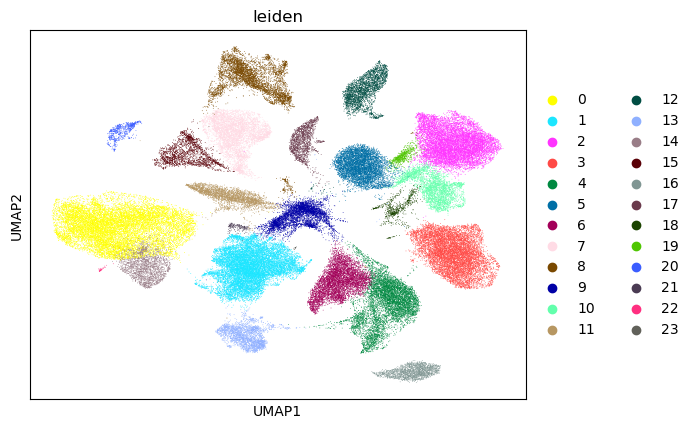

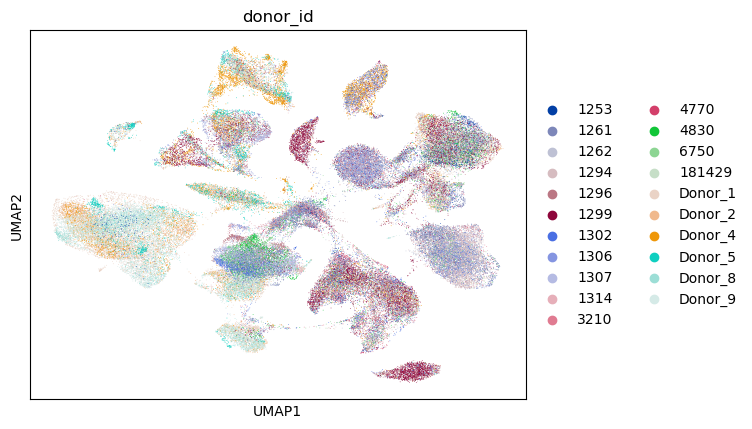

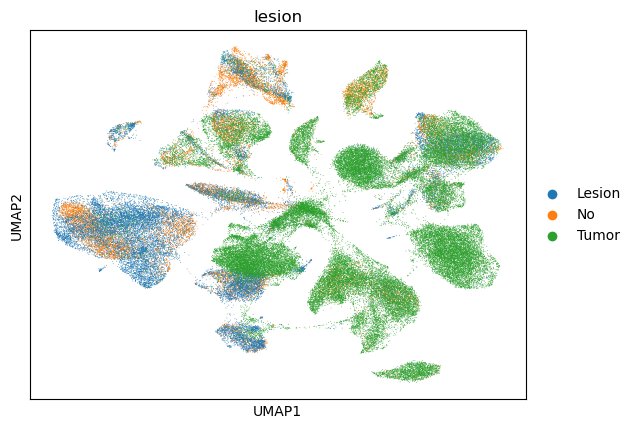

In [43]:
# Compute clusters
sc.tl.leiden(adata_all_hvg, resolution=0.5)
# Compute UMAP embedding
sc.tl.umap(adata_all_hvg)
# Plot UMAP colored by cluster, donor, and lesion
sc.pl.umap(adata_all_hvg, color=['leiden'])
sc.pl.umap(adata_all_hvg, color=['donor_id'])
sc.pl.umap(adata_all_hvg, color=['lesion'])

#### Cell type annotation: comparison of several methods

#### 14. Manual annotation using top 20 marker genes

In [45]:
sc.tl.rank_genes_groups(adata_all_hvg, 'leiden', method='wilcoxon', use_raw=True)

C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:463: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

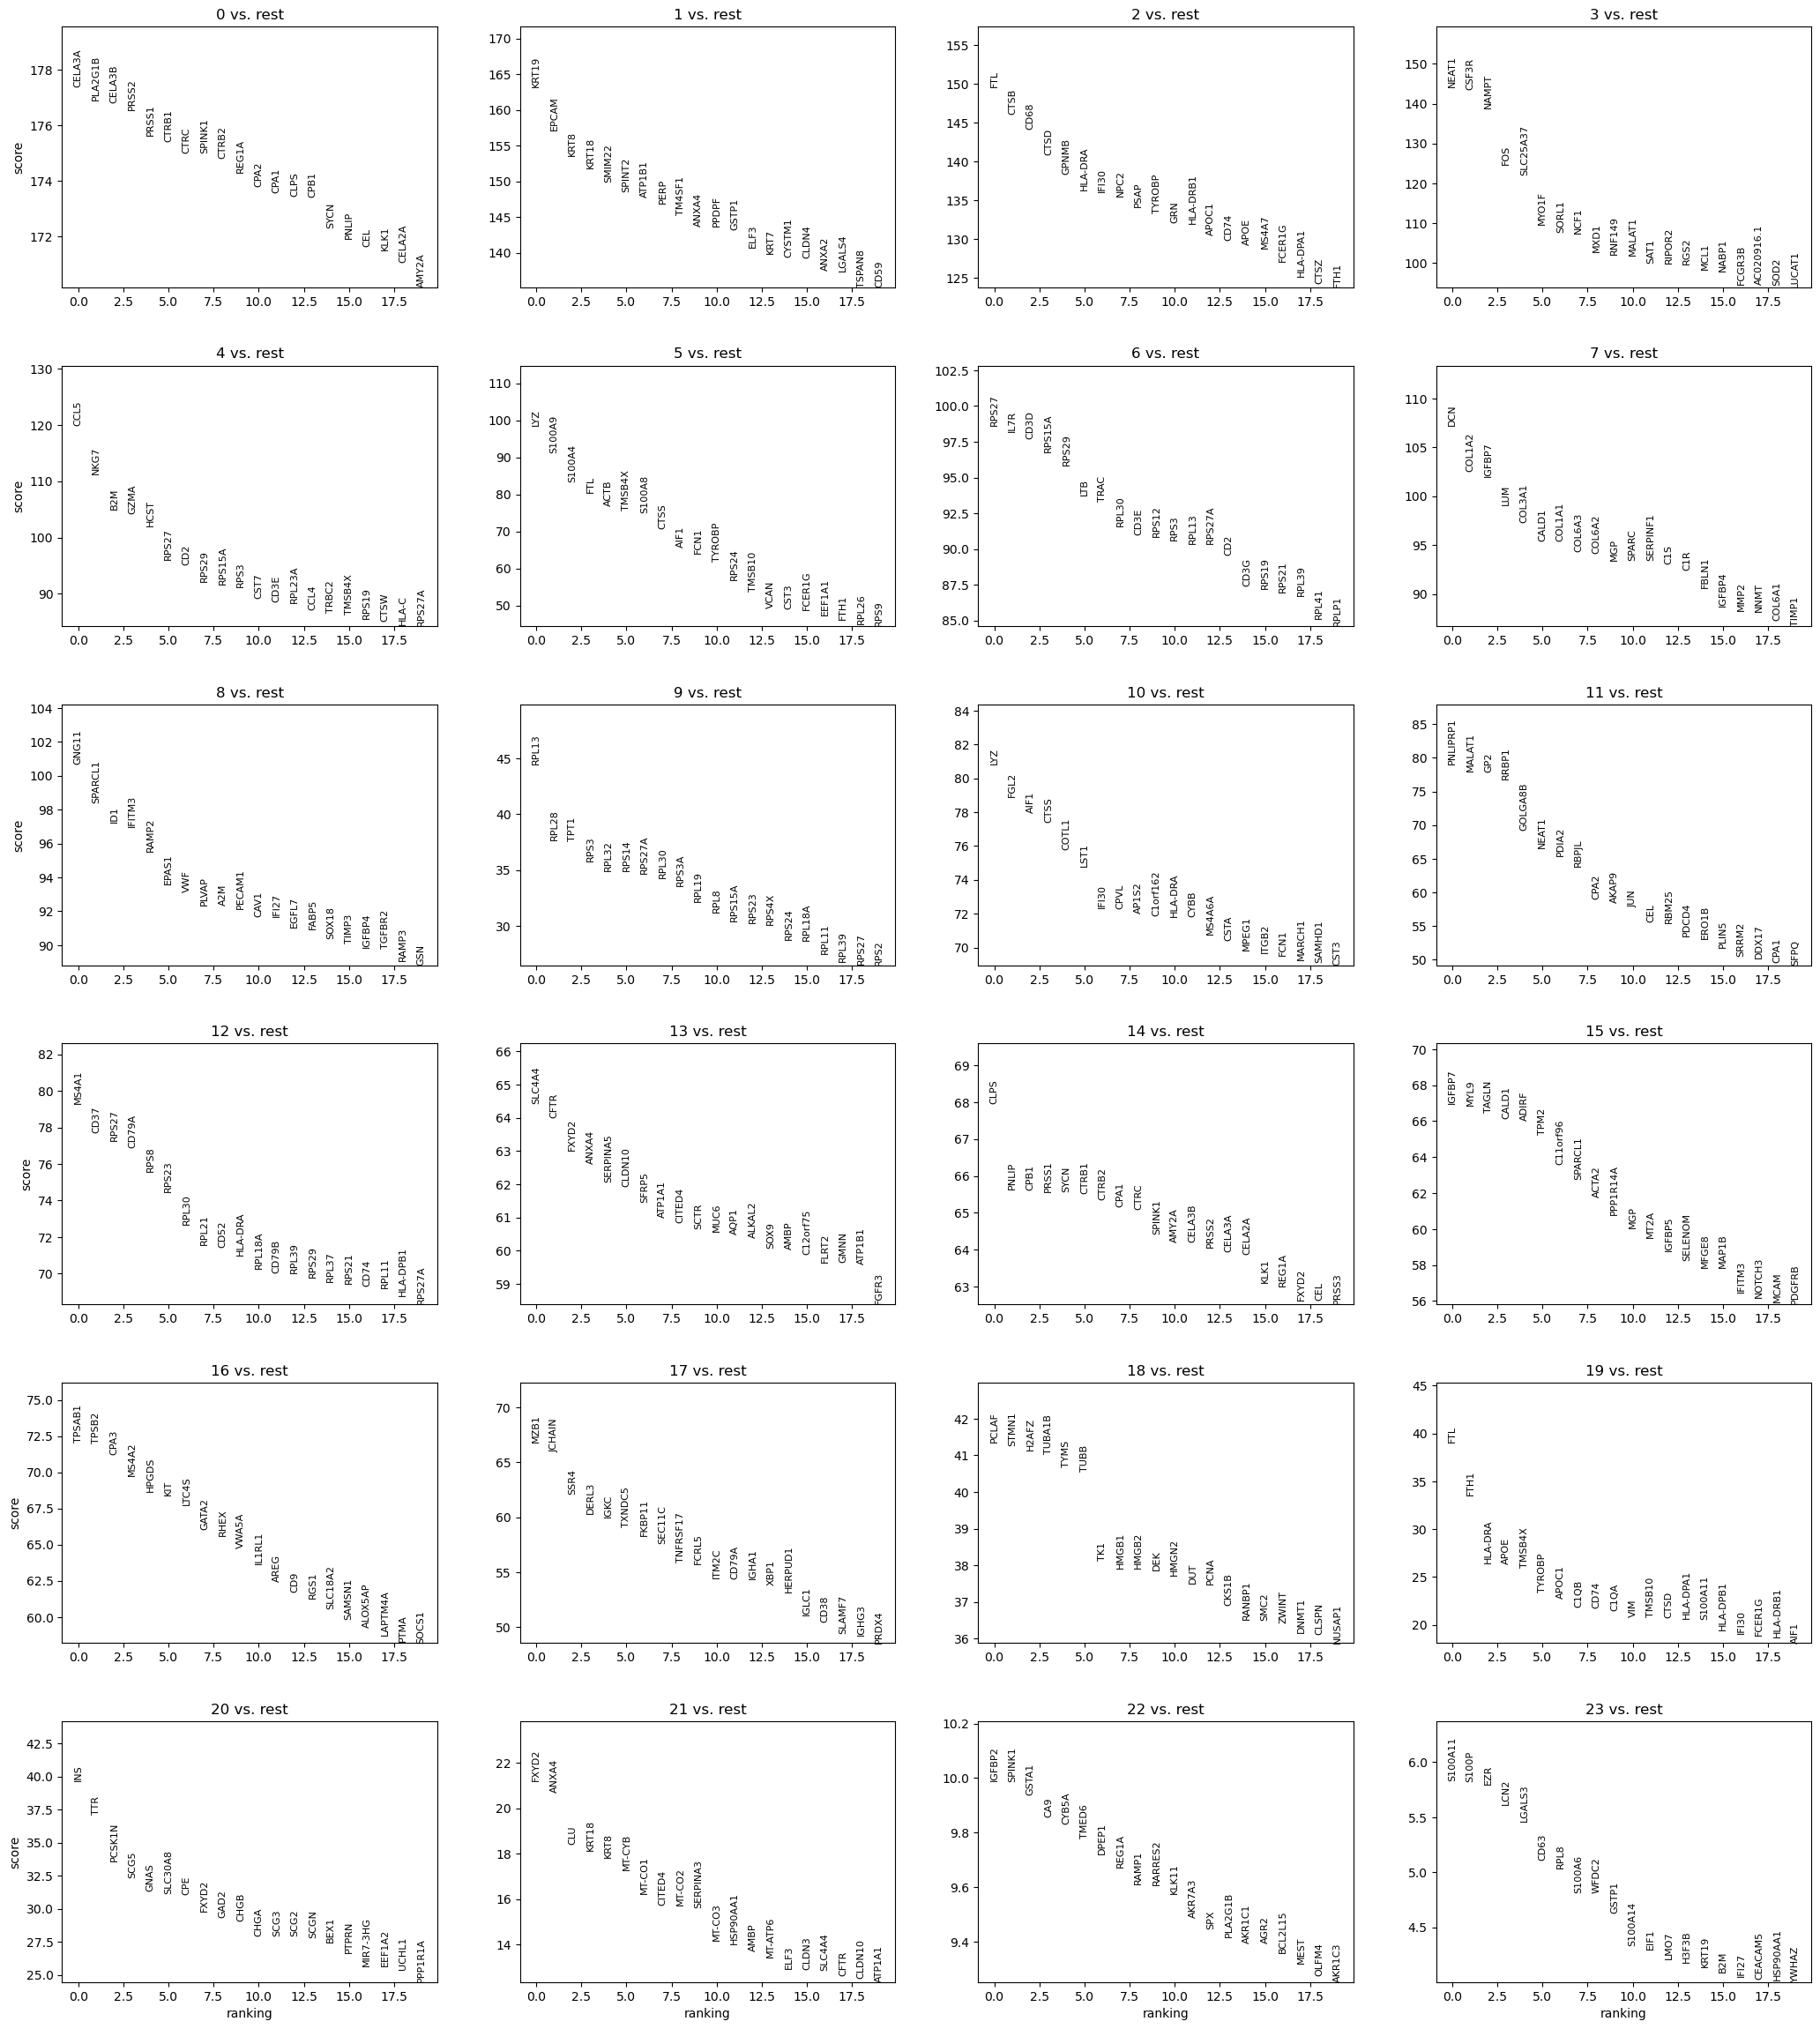

In [46]:
sc.pl.rank_genes_groups(adata_all_hvg, n_genes = 20, sharey = False)

In [47]:
df = sc.get.rank_genes_groups_df(adata_all_hvg, None)

In [48]:
# Dictionary to store top marker genes for each Leiden cluster
top_markers_per_cluster = {}

# Loop over all Leiden cluster labels
for cluster in adata_all_hvg.obs['leiden'].cat.categories:
    
    # Select rows in the DataFrame corresponding to the current cluster
    cluster_df = df[df['group'] == cluster]
    
    # Sort marker genes by their ranking score (highest first)
    cluster_df = cluster_df.sort_values('scores', ascending=False)
    
    # Select the top 20 gene names for this cluster
    top_genes = cluster_df['names'].head(20).tolist()
    
    # Store the list of top genes in the dictionary
    # Key = cluster label, Value = list of top marker genes
    top_markers_per_cluster[cluster] = top_genes

# Inspect the resulting dictionary
print(top_markers_per_cluster)

{'0': ['CELA3A', 'PLA2G1B', 'CELA3B', 'PRSS2', 'PRSS1', 'CTRB1', 'CTRC', 'SPINK1', 'CTRB2', 'REG1A', 'CPA2', 'CPA1', 'CLPS', 'CPB1', 'SYCN', 'PNLIP', 'CEL', 'KLK1', 'CELA2A', 'AMY2A'], '1': ['KRT19', 'EPCAM', 'KRT8', 'KRT18', 'SMIM22', 'SPINT2', 'ATP1B1', 'PERP', 'TM4SF1', 'ANXA4', 'PPDPF', 'GSTP1', 'ELF3', 'KRT7', 'CYSTM1', 'CLDN4', 'ANXA2', 'LGALS4', 'TSPAN8', 'CD59'], '2': ['FTL', 'CTSB', 'CD68', 'CTSD', 'GPNMB', 'HLA-DRA', 'IFI30', 'NPC2', 'PSAP', 'TYROBP', 'GRN', 'HLA-DRB1', 'APOC1', 'CD74', 'APOE', 'MS4A7', 'FCER1G', 'HLA-DPA1', 'CTSZ', 'FTH1'], '3': ['NEAT1', 'CSF3R', 'NAMPT', 'FOS', 'SLC25A37', 'MYO1F', 'SORL1', 'NCF1', 'MXD1', 'RNF149', 'MALAT1', 'SAT1', 'RIPOR2', 'RGS2', 'MCL1', 'NABP1', 'FCGR3B', 'AC020916.1', 'SOD2', 'LUCAT1'], '4': ['CCL5', 'NKG7', 'B2M', 'GZMA', 'HCST', 'RPS27', 'CD2', 'RPS29', 'RPS15A', 'RPS3', 'CST7', 'CD3E', 'RPL23A', 'CCL4', 'TRBC2', 'TMSB4X', 'RPS19', 'CTSW', 'HLA-C', 'RPS27A'], '5': ['LYZ', 'S100A9', 'S100A4', 'FTL', 'ACTB', 'TMSB4X', 'S100A8', 'CTS

In [60]:
cluster_to_celltype = {
    '0': 'Acinar cells; strong pancreatic acinar cell signature',
    '1': 'Ductal epithelial cells',
    '2': 'Monocytes / macrophages',
    '3': 'Neutrophils / granulocytes',
    '4': 'T cells / cytotoxic',
    '5': 'Monocytes / inflammatory macrophages',
    '6': 'T cells / naive',
    '7': 'Fibroblasts / stromal',
    '8': 'Endothelial cells',
    '9': 'Cycling cells',
    '10': 'Monocytes / tissue-resident macrophages',
    '11': 'Acinar cells; GP2 gene marker',
    '12': 'B cells / plasma cell precursors',
    '13': 'Ductal epithelial cells; CFTR and FXYD2 (ion transport)',
    '14': 'Acinar cells; likely a subpopulation of acinar cells',
    '15': 'Pericytes / smooth muscle cells',
    '16': 'Mast cells',
    '17': 'Plasma cells',
    '18': 'Cycling cells; cell cycle markers',
    '19': 'Macrophages / microglia-like',
    '20': 'Beta cells / endocrine; insulin + secretory granule genes',
    '21': 'Ductal epithelial cells; ion-transporting epithelium',
    '22': 'Acinar cells; markers; digestive enzymes + trypsin inhibitor SPINK1',
    '23': 'Ductal / progenitor-like epithelial cells'
}

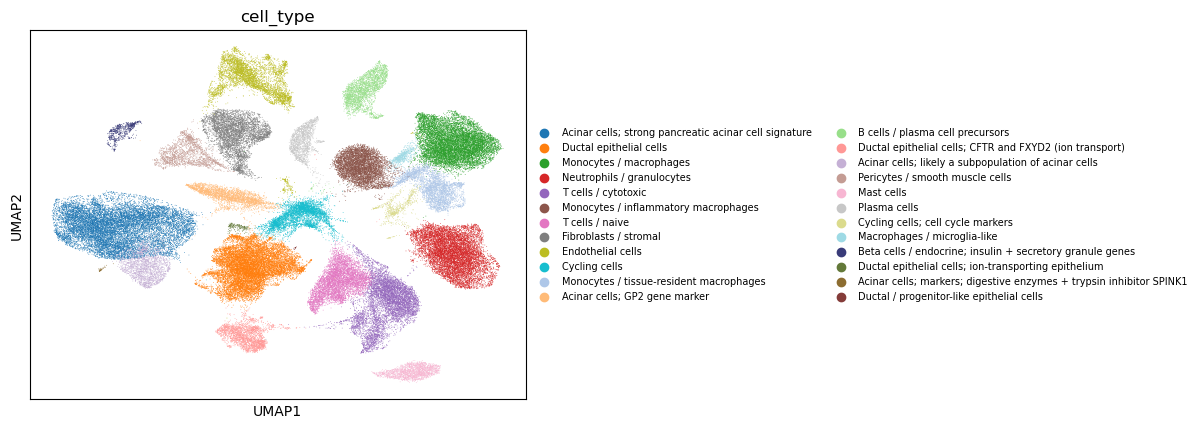

In [61]:
adata_all_hvg.obs['cell_type'] = (
    adata_all_hvg.obs['leiden']
    .map(cluster_to_celltype)
    .astype('category')
)
palette_24 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#aec7e8", "#ffbb78",
    "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7",
    "#dbdb8d", "#9edae5", "#393b79", "#637939", "#8c6d31", "#843c39"
]

sc.pl.umap(adata_all_hvg, color='cell_type', palette = palette_24, legend_loc='right margin', legend_fontsize=7)

#### 15. Cell type annotation with Celltypist
##### Celltypist uses a logistic regression classifier trained on annotated single-cell RNA-seq reference datasets

In [62]:
# Load your model
model = celltypist.models.Model.load(model='Adult_Human_PancreaticIslet.pkl')

In [64]:
# Run annotation in probability mode
predictions = celltypist.annotate(adata_all, model=model, majority_voting=True, mode='prob match')

🔬 Input data has 141116 cells and 28935 genes
🔗 Matching reference genes in the model
🧬 1874 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [65]:
# Get probability matrix
probs = predictions.probability_matrix

In [66]:
# Determine predicted label per cell
predicted_labels = probs.idxmax(axis=1)

In [68]:
# Apply probability threshold
threshold = 0.5
predicted_labels[probs.max(axis=1) < threshold] = 'other'

In [69]:
# Store in AnnData
adata_all.obs['predicted_labels'] = predicted_labels

In [71]:
adata_all.obs.head(3)

,sample_id,donor_id,lesion,n_genes_by_counts,total_counts,total_counts_Ribosomal,pct_counts_Ribosomal,log1p_n_genes_by_counts,log1p_total_counts,pct_counts_in_top_50_genes,...,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,log1p_total_counts_Ribosomal,doublet_score,predicted_doublet,S_score,G2M_score,phase,predicted_labels
TACCGAACATCGATGT-1-3829-EC,3829-EC,Donor_1,Lesion,9730,781255,160919,20.59750,9.183072,13.568658,74.444580,...,2323,7.751045,0.297342,11.988663,0.063197,False,-0.015247,-0.072767,G1,other
CACTGTCTCCCTTTGG-1-3829-EC,3829-EC,Donor_1,Lesion,9772,756935,191638,25.31763,9.187379,13.537034,71.134113,...,1157,7.054450,0.152853,12.163369,0.058739,False,-0.015644,-0.073749,G1,other
GGTTAACAGCAACTCT-1-3829-EC,3829-EC,Donor_1,Lesion,10572,635900,159201,25.03554,9.266059,13.362798,63.622268,...,2995,8.005033,0.470986,11.977929,0.113208,False,-0.026120,-0.090514,G1,other


... storing 'predicted_labels' as categorical


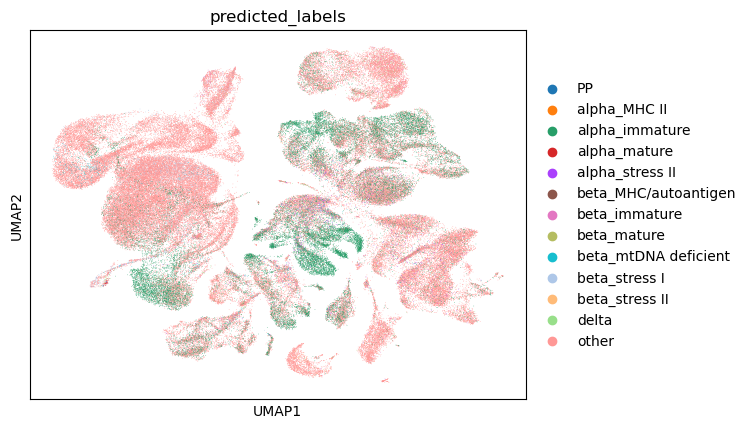

In [72]:
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color='predicted_labels')

In [73]:
percentages = adata_all.obs['predicted_labels'].value_counts(normalize=True) * 100
print(percentages)

predicted_labels
other                   73.751382
alpha_immature          20.609995
beta_stress I            1.606480
beta_immature            1.118938
alpha_stress II          0.913433
delta                    0.780209
beta_mtDNA deficient     0.498172
beta_stress II           0.384081
beta_mature              0.268573
alpha_mature             0.058108
PP                       0.005669
beta_MHC/autoantigen     0.003543
alpha_MHC II             0.001417
Name: proportion, dtype: float64


#### 16. Use scVI : single-cell Variational Inference
##### Deep variational autoencoder that learns a low-dimensional latent representation of single-cell RNA-seq count data by modeling gene expression with probabilistic distributions while correcting for technical effects (batch, library size, covariates)
##### (!) It is necessary to use raw, non-normalized count data with scVI because the model directly learns from integer counts and performs its own internal normalization (e.g., modeling library size and gene expression with a negative binomial distribution) as part of its probabilistic framework

In [19]:
# Concatenate the samples
adata_all_for_scvi = sc.concat(adatas, join="outer", label="sample_id", index_unique="-")

In [20]:
adata_all_for_scvi.obs.columns

Index(['sample_id', 'donor_id', 'lesion', 'n_genes_by_counts', 'total_counts',
       'total_counts_Ribosomal', 'pct_counts_Ribosomal',
       'log1p_n_genes_by_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'log1p_total_counts_Ribosomal', 'doublet_score', 'predicted_doublet'],
      dtype='object')

In [21]:
# Copy the dataset
adata_training = adata_all_for_scvi.copy()

In [22]:
# Ensure the batch column is string
adata_training.obs['donor_id'] = adata_training.obs['donor_id'].astype(str)

In [26]:
# Compute cell cycle scores (raw counts ok)
sc.tl.score_genes_cell_cycle(adata_training, s_genes=s_genes, g2m_genes=g2m_genes)

In [27]:
sc.pp.highly_variable_genes(
    adata_training,
    n_top_genes=3000,
    flavor = "seurat_v3",
    batch_key="donor_id")

# Apply HVGs to full dataset
adata_training = adata_training[:, adata_training.var['highly_variable']].copy()

In [30]:
# Identify categorical/string columns as strings
categorical_cols = ['sample_id', 'donor_id', 'lesion', 'phase']

# Convert them to strings
for col in categorical_cols:
    adata_training.obs[col] = adata_training.obs[col].astype(str)

# Save your concatenated object
adata_training.write("C:/Users/ksenia/adata_all_for_scvi.h5ad")

... storing 'sample_id' as categorical
... storing 'donor_id' as categorical
... storing 'lesion' as categorical
... storing 'phase' as categorical


##### (!!!) Steps A to E were performed in AWS VM (1 GPU, 4 vCPU, 16 Gb RAM)

In [38]:
# STEP A
# Setup SCVI AnnData
SCVI.setup_anndata(
    adata_training,
    batch_key='donor_id',
    categorical_covariate_keys=['lesion'],
    continuous_covariate_keys=['S_score', 'G2M_score'])

In [39]:
# STEP B
# Allow writing nullable string arrays in AnnData
ad.settings.allow_write_nullable_strings = True

# Load your AnnData object
adata_training = sc.read_h5ad("/home/ubuntu/scvi_model/adata_training.h5ad")

# Initialize SCVI model: the parameters were taken from https://huggingface.co/scvi-tools/tabula-sapiens-pancreas-scvi
# The Tabula Sapiens Consortium. Science, May 2022. doi:10.1126/science.abl4896
model = SCVI(
    adata_training,
    n_hidden=128,
    n_latent=20,
    n_layers=3,
    dropout_rate=0.05,
    dispersion="gene",
    gene_likelihood="nb",
    latent_distribution="normal",
    use_batch_norm="none",
    use_layer_norm="both",
    encode_covariates=True)

In [ ]:
# STEP C
# Train SCVI
model.train(max_epochs=150)

In [ ]:
# STEP D
# Save the model
model.save("/home/ubuntu/scvi_model/trained_model/", overwrite=True)

In [ ]:
# STEP E
# Get latent embeddings
adata_training.obsm["X_scVI"] = model.get_latent_representation() # compressed representation of the cells in a lower-dimensional space

# Save new AnnData
adata_training.write("/home/ubuntu/scvi_model/adata_training_latent_emb.h5ad")

In [9]:
# Load the AnnData
adata_training_latent_emb = sc.read_h5ad("C:/Users/ksenia/scvi_model/adata_training_latent_emb.h5ad")

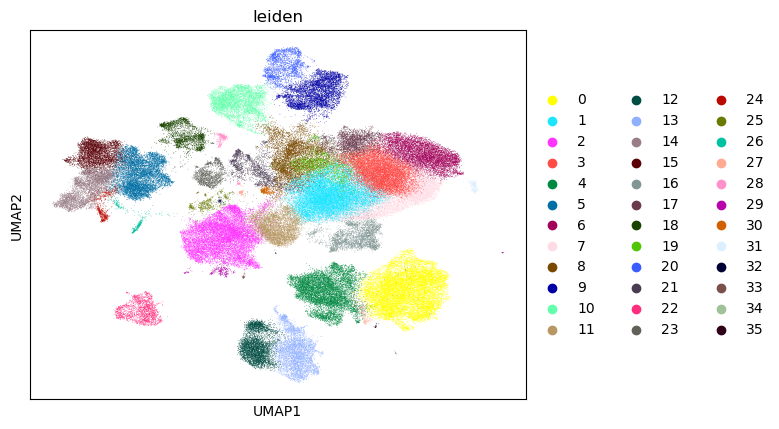

In [14]:
# UMAP visualization
sc.pp.neighbors(adata_training_latent_emb, use_rep="X_scVI")
sc.tl.umap(adata_training_latent_emb)
sc.tl.leiden(adata_training_latent_emb)
sc.pl.umap(adata_training_latent_emb, color=["leiden"])

In [19]:
# Copy the current AnnData into .raw
adata_training_latent_emb.raw = adata_training_latent_emb.copy()

In [20]:
# Normalize total counts per cell
sc.pp.normalize_total(adata_training_latent_emb, target_sum=1e4)

In [21]:
# Log-transform
sc.pp.log1p(adata_training_latent_emb)

In [23]:
sc.tl.rank_genes_groups(adata_training_latent_emb, 'leiden', method='wilcoxon', use_raw=True)

C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:481: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\ksenia\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:481: RuntimeWarning: ove

In [24]:
df_scvi = sc.get.rank_genes_groups_df(adata_training_latent_emb, None)

In [28]:
# Dictionary to store top marker genes for each Leiden cluster
top_markers_per_cluster = {}

# Loop over all Leiden cluster labels
for cluster in adata_training_latent_emb.obs['leiden'].cat.categories:
    
    # Select rows in the DataFrame corresponding to the current cluster
    cluster_df = df_scvi[df_scvi['group'] == cluster]
    
    # Sort marker genes by their ranking score (highest first)
    cluster_df = cluster_df.sort_values('scores', ascending=False)
    
    # Select the top 10 gene names for this cluster
    top_genes = cluster_df['names'].head(10).tolist()
    
    # Store the list of top genes in the dictionary
    top_markers_per_cluster[cluster] = top_genes

# Inspect the resulting dictionary
print(top_markers_per_cluster)

{'0': ['TYROBP', 'HLA-DRA', 'FCER1G', 'IFI30', 'CD68', 'CTSB', 'AIF1', 'HLA-DRB1', 'FTL', 'LAPTM5'], '1': ['SLC4A4', 'FXYD2', 'CFTR', 'AMY2A', 'PNLIP', 'CPB1', 'CLPS', 'SYCN', 'GP2', 'CPA1'], '2': ['KRT19', 'C19orf33', 'S100A6', 'IFI27', 'S100P', 'FXYD3', 'MSLN', 'CAMK2N1', 'SLPI', 'AGR2'], '3': ['GP2', 'CEL', 'CPB1', 'CPA2', 'CLPS', 'CTRC', 'CPA1', 'CTRB1', 'PNLIPRP1', 'CTRB2'], '4': ['S100A9', 'LYZ', 'S100A8', 'FCN1', 'AIF1', 'CTSS', 'S100A4', 'VCAN', 'TYROBP', 'FCER1G'], '5': ['LTB', 'IL7R', 'CD3D', 'TRAC', 'CD3E', 'CD52', 'CD3G', 'TRBC2', 'CD2', 'PTPRC'], '6': ['CELA3B', 'PRSS2', 'PLA2G1B', 'PRSS3', 'CELA3A', 'PRSS1', 'CTRB1', 'CELA2A', 'CPA1', 'CTRL'], '7': ['REG3A', 'AMY2A', 'PNLIP', 'AMY2B', 'SYCN', 'CLPS', 'CELA2A', 'CPB1', 'CPA1', 'REG3G'], '8': ['INS', 'REG3A', 'OLFM4', 'REG1B', 'PNLIP', 'CLPS', 'AMY2A', 'CPB1', 'CTRB2', 'PRSS1'], '9': ['DCN', 'COL1A2', 'LUM', 'IGFBP7', 'COL3A1', 'COL1A1', 'COL6A3', 'MGP', 'CALD1', 'SPARC'], '10': ['SPARCL1', 'IFI27', 'PLVAP', 'GNG11', 'RAMP2

In [29]:
cluster_to_celltype = {
    '0': 'Macrophages / monocytes; myeloid, antigen-presenting',
    '1': 'Acinar cells; exocrine pancreas',
    '2': 'Ductal epithelial cells',
    '3': 'Acinar cells; exocrine pancreas subcluster',
    '4': 'Inflammatory myeloid / monocytes / neutrophils',
    '5': 'T cells; naive / helper T',
    '6': 'Acinar cells; exocrine pancreas',
    '7': 'Acinar cells / secretory subcluster',
    '8': 'Beta cells; insulin-producing',
    '9': 'Fibroblasts / stromal cells',
    '10': 'Endothelial cells',
    '11': 'Ductal epithelial cells',
    '12': 'Neutrophils / granulocytes',
    '13': 'Neutrophils',
    '14': 'NK cells / cytotoxic lymphocytes',
    '15': 'T cells',
    '16': 'Acinar cells',
    '17': 'Ductal cells / pancreatic progenitors',
    '18': 'B cells',
    '19': 'Acinar cells',
    '20': 'Smooth muscle / pericytes',
    '21': 'Beta cells',
    '22': 'Mast cells',
    '23': 'Plasma cells',
    '24': 'NK / cytotoxic T cells',
    '25': 'Stromal / mesenchymal cells',
    '26': 'Cytotoxic lymphocytes / plasma cells',
    '27': 'Dendritic cells / antigen-presenting',
    '28': 'B cells',
    '29': 'Ductal / epithelial cells; secretory',
    '30': 'Plasma cells',
    '31': 'Acinar cells',
    '32': 'Mesenchymal / progenitor cells',
    '33': 'Epithelial cells; hypoxia response',
    '34': 'Acinar cells',
    '35': 'Dendritic cells / myeloid antigen-presenting'
}

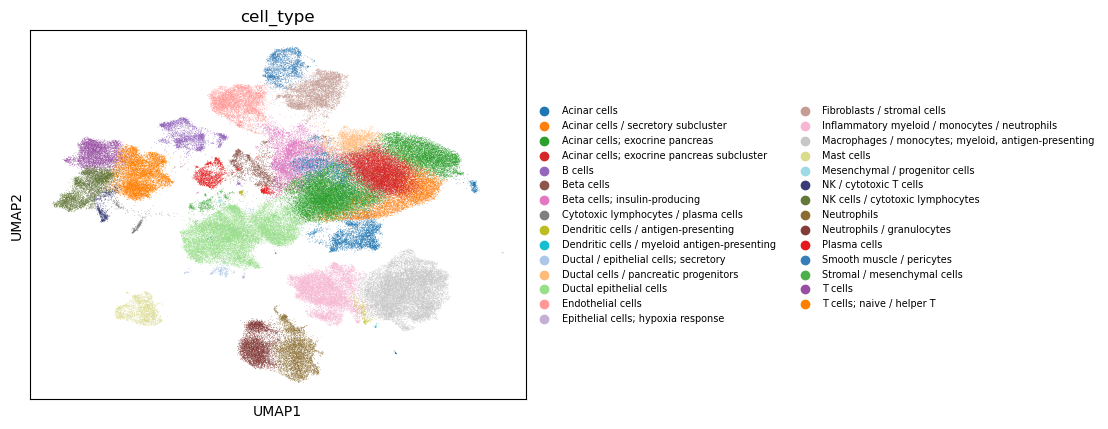

In [33]:
adata_training_latent_emb.obs['cell_type'] = (
    adata_training_latent_emb.obs['leiden']
    .map(cluster_to_celltype)
    .astype('category')
)
palette_36_contrast = [
    "#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
    "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99",
    "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3", "#fdb462",
    "#b3de69", "#fccde5", "#d9d9d9", "#bc80bd", "#ccebc5", "#ffed6f",
    "#ff0000", "#00ff00", "#0000ff", "#ff00ff", "#00ffff", "#ffa500",
    "#800000", "#008000", "#000080", "#808000", "#800080", "#008080"
]
sc.pl.umap(adata_training_latent_emb, color='cell_type', palette = palette_36, legend_loc='right margin', legend_fontsize=7)